# Create and Train a quantized MLP on the UNSW_NB15 dataset

In this notebook, we will show how to create, train and export a quantized Multi Layer Perceptron with binary weights and activations with Brevitas library. Specifically, we will train this quantized MLP on the quantized version of the UNSW_NB15 dataset, and then export the model to ONNX.

# The UNSW_NB15 Dataset Description
The [UNSW_NB15](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/) is one of the latest dataset created by the Australian Centre for Cyber Security (ACCS). The IXIA PerfectStorm tool created more than 100GB of raw traffic. The total number of records is two million and 540,044 which are stored in four CSV files. However, only a subset is used, more specifically 257,673 records, split in two files: ["UNSW_NB15_training-set.csv"](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv) and [" UNSW_NB15_testing-set.csv"](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv) which can be downloaded from the website.


In this notebook a binary classification was applied, where the feature "label" identifies the record as an attack or as normal traffic. Prior to quantization, all features that are strings were converted to numbers with integer encoding. Quantization was done in python and mimics this [matlab script](https://github.com/TadejMurovic/BNN_Deployment/blob/master/cybersecurity_dataset_unswb15.m).


In [1]:
!pip install --user pandas
!pip install --user scikit-learn
!pip install --user tqdm

## Outline
-------------
1. [Define Auxilary Method and Parameters ](#auxilary_&_parameters)
2. [Define the quantized MLP model class](#create_model)
3. [Define the Train and Test methods](#train_test) 
4. [Define the Loss and Optimizer](#loss_optimizer)
5. [Load the UNSW_NB15 dataset](#load_dataset)
6. [Train, Test and see the Loss](#train_test_loss)
7. [Change the model structure after training](#change_model)
8. [Brevitas export](#brevitas_export)

# 1. Define Auxilary Method and Parameters <a id='auxilary_&_parameters'></a>

Before we start creating our Multi Layer Perceptron we need to define the topology structure and some needed parameters. Specifically the nodes in each layer of the MLP, the number of epochs, batch size and learning rate.

Moreover, in order to watch the loss function evolution over epochs, we need to define a method for it.

In [2]:
def display_loss_plot(losses):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title('Loss of the model')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.show()

In [3]:
input_size = 593      
hidden1 = 128      
hidden2 = 64
hidden3 = 32
num_classes = 1    

num_epochs = 3
batch_size = 100 
lr = 0.001 

# 2. Define the Quantized MLP model <a id='1create_model'></a>
The model is a quantized MLP model with 1-bit weights and 1-bit activations implemented with [Brevitas](https://github.com/Xilinx/brevitas). Brevitas is a PyTorch library for quantization-aware training. The MLP has 4 FC layers, each layer has 593, 128, 64, 32 and 1 node. Between each FC layer, Batchnorm is applied. The activation function is a Quantized Identity function.

In [4]:
from dependencies import value

from brevitas.inject import BaseInjector as Injector
from brevitas.core.bit_width import BitWidthImplType
from brevitas.core.quant import QuantType
from brevitas.core.restrict_val import RestrictValueType
from brevitas.core.scaling import ScalingImplType

class CommonQuant(Injector):
    bit_width_impl_type = BitWidthImplType.CONST
    scaling_impl_type = ScalingImplType.CONST
    restrict_scaling_type = RestrictValueType.FP
    scaling_per_output_channel = False
    narrow_range = True
    signed = True

    @value
    def quant_type(bit_width):
        if bit_width is None:
            return QuantType.FP
        elif bit_width == 1:
            return QuantType.BINARY
        else:
            return QuantType.INT

class CommonWeightQuant(CommonQuant):
    scaling_const = 1.0

class CommonActQuant(CommonQuant):
    min_val = -1.0
    max_val = 1.0

In [5]:
from brevitas.nn import QuantIdentity, QuantConv2d, QuantReLU, QuantLinear, QuantHardTanh
import torch.nn as nn

weight_bit_width = 1
act_bit_width = 1

class QuantMLP(nn.Module):
    def __init__(self, input_size,hidden1, hidden2, hidden3, num_classes):
        super(QuantMLP, self).__init__()
        self.fc1   = QuantLinear(input_size, hidden1, bias=False, weight_bit_width=weight_bit_width, weight_quant=CommonWeightQuant)
        self.batchnorm1 = nn.BatchNorm1d(hidden1)
        self.identity1 = QuantIdentity(act_quant=CommonActQuant, bit_width=act_bit_width)
        
        self.fc2   = QuantLinear(hidden1, hidden2, bias=False, weight_bit_width=weight_bit_width, weight_quant=CommonWeightQuant)
        self.batchnorm2 = nn.BatchNorm1d(hidden2)
        self.identity2 = QuantIdentity(act_quant=CommonActQuant, bit_width=act_bit_width)
        
        self.fc3   = QuantLinear(hidden2, hidden3, bias=False, weight_bit_width=weight_bit_width, weight_quant=CommonWeightQuant)
        self.batchnorm3 = nn.BatchNorm1d(hidden3)
        self.identity3 = QuantIdentity(act_quant=CommonActQuant, bit_width=act_bit_width)
        
        self.fc4   = QuantLinear(hidden3, num_classes, bias=False, weight_bit_width=weight_bit_width, weight_quant=CommonWeightQuant)
        self.batchnorm4 = nn.BatchNorm1d(num_classes)       


    def forward(self, x):
        fc1 = self.fc1(x)
        b1 = self.batchnorm1(fc1)
        identity1 = self.identity1(b1)
        
        fc2 = self.fc2(identity1)
        b2 = self.batchnorm2(fc2)
        identity2 = self.identity2(b2)

        fc3 = self.fc3(identity2)
        b3 = self.batchnorm3(fc3)
        identity3 = self.identity3(b3)
        
        fc4 = self.fc4(identity3)
        b4 = self.batchnorm4(fc4)
    
        return b4

model = QuantMLP(input_size, hidden1, hidden2, hidden3, num_classes)

# 3. Define Train and Test  methods  <a id='train_test'></a>
The train and test methods use the Dataloader, which feeds the model with a new predefined batch of training data in each iteration, until the entire training data is fed to the model.

In [6]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    model.train()
    y_true = []
    y_pred = []
    
    for i, data in enumerate(train_loader, 0):        
        inputs , target = data
        optimizer.zero_grad()   
                
        #FORWARD PASS
        output = model(inputs.float())
        loss = criterion(output, target.unsqueeze(1))
        
        #BACKWARD AND OPTIMIZE        
        loss.backward()
        optimizer.step()
        
        # PREDICTIONS
        pred = output.detach().numpy() > 0.5  
        target = target.float()
        y_true.extend(target.tolist()) 
        y_pred.extend(pred.reshape(-1).tolist())
        
        losses.append(loss.data.numpy()) 
        
    model.eval()    
    return losses

In [7]:
def test(model, test_loader):    
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            
            inputs ,target = data
            output = torch.sigmoid(model(inputs.float()))  
            
            #PREDICTIONS
            pred = (output.detach().numpy() > 0.5) *1
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

# 4. Define the Loss and Optimizer <a id="loss_optimizer"></a>

The loss will be a BCEWithLogitsLoss. It already applies a sigmoid to its output.

In [8]:
import onnx 
import torch

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# 5. Load the UNSW_NB15 dataset <a id='load_dataset'></a>
This UNSW_NB15_quantized class implements a DataLoader class. This is useful because enables access to data in batches. This class contains a fully quantized dataset with values {0,1}

### Download the training and test set from the [official website](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/)

In [9]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv

In [10]:
from torch.utils.data import DataLoader, Dataset
from dataloader import UNSW_NB15
from dataloader_quantized import UNSW_NB15_quantized

file_path_train = "UNSW_NB15_training-set.csv"
file_path_test = "UNSW_NB15_testing-set.csv"

train_quantized_dataset = UNSW_NB15_quantized(file_path_train = file_path_train, \
                                              file_path_test = file_path_test, \
                                              train=True)
train_quantized_loader = DataLoader(train_quantized_dataset, batch_size=batch_size, shuffle=True)

test_quantized_dataset = UNSW_NB15_quantized(file_path_train = file_path_train, \
                                              file_path_test = file_path_test, \
                                              train=False)
test_quantized_loader = DataLoader(test_quantized_dataset, batch_size=batch_size, shuffle=True)

torch.Size([175341, 594])
torch.Size([82332, 594])


# 6. Train, Test the model and Verify the Loss <a id="train_test_loss"></a>

Now that we have everything defined, we can finally train the quantized MLP on the quantized dataset. Then, test its accuracy and watch the loss function evolution over epochs.

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

running_loss = []
for epoch in tqdm(range(num_epochs)):
        loss_epoch = train(model, train_quantized_loader, optimizer,criterion)
        running_loss.append(loss_epoch)

100%|██████████| 3/3 [00:51<00:00, 17.28s/it]


In [12]:
test(model,test_quantized_loader)

0.8452970898314143

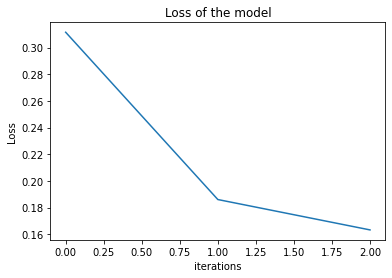

In [16]:
import matplotlib.pyplot as plt

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

# 7. Change  the model after training <a id="change_model"></a>

The model is trained on the UNSW_NB15 dataset, but now we need to change its output to belong to {-1,+1}. Therefore we need to add a layer before its output, such as a Quantized Identity layer. 

Furthermore, the input will changed, so instead of the {0,+1} the input will now accept {-1,1} as valid input values.

In [14]:
# save the state_dict
path = "quantized_mlp_unsw_nb15.pt"
torch.save(model.state_dict(), path)

# load the state_dict and create new model with aditional QuantIdentity layer
new_model_to_be = QuantMLP(input_size, hidden1, hidden2, hidden3, num_classes)
new_model_to_be.load_state_dict(torch.load(path))  
new_model_to_be.eval()

class extended_model(nn.Module):
    def __init__(self, my_pretrained_model):
        super(extended_model, self).__init__()
        self.pretrained = my_pretrained_model
        self.identity = QuantIdentity(act_quant=CommonActQuant, bit_width=1)
    
    def forward(self, x):
        x = (x + torch.tensor([1.0])) / 2.0  # shift from {-1,1} {0,1} 
        out_original = self.pretrained(x)
        out_final = self.identity(out_original)   # output as {-1,1}     
        return out_final

new_model = extended_model(my_pretrained_model=new_model_to_be)
new_model.eval()
new_model_output = new_model.forward(test_quantized_dataset.data[:,:-1] * 2.0 - torch.tensor([1.0])) # feed data as {-1,1}
new_model_output = new_model_output

# 8. Brevitas export <a id="brevitas_export" ></a>

FINN expects an ONNX model as input. This can be a model trained with [Brevitas](https://github.com/Xilinx/brevitas). First a few things have to be imported. Then the model can be loaded with the pretrained weights. 

In [15]:
import brevitas.onnx as bo

export_onnx_path = "brevitas_w%d_a%-uNSW_NB15_model.onnx" % (weight_bit_width, act_bit_width)
input_shape = (1, 593)
bo.export_finn_onnx(new_model, input_shape, export_onnx_path)

new_model.eval
print("Model saved to %s" % export_onnx_path)

Model saved to brevitas_w1_a1NSW_NB15_model.onnx


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.


# That's it!
You created, trained and tested a quantized MLP that is ready to be loaded into FINN! Congrats!

<img src="https://media1.tenor.com/images/2386d12e54aa11ce0298d100954d982a/tenor.gif?itemid=4115627" >